# Creating the Initial Conditions

First, import packages to re-create and visualize the model fields here:

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata


# Define the Model Grid and Domain

We will define the model grid based on your previous configuration.

In [15]:
# Define grid parameters
delX = 1/12
delY = 1/16
xgOrigin = -175
ygOrigin = 55
n_rows = 360
n_cols = 240

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX+delX/2, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

print('Model grid dimensions:', XC.shape)


Model grid dimensions: (360, 240)


# Load Bathymetry Data

We will read the bathymetry.bin file generated in the previous notebook. This bathymetry data will help us define the land-sea mask for our model grid.

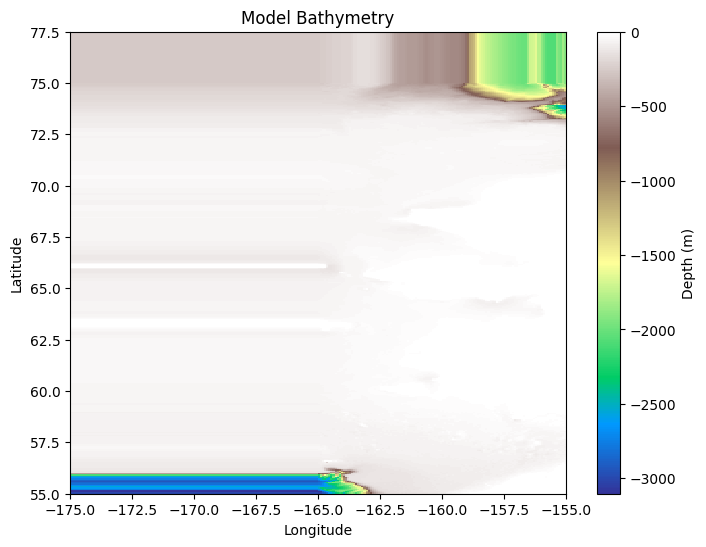

In [16]:
# Define the path to the bathymetry file
bathymetry_file = 'C:\\Users\\Daniel\\Desktop\\185C_Project\\input\\CA_bathymetry.bin'

# Read the bathymetry data
Model_bathy = np.fromfile(bathymetry_file, '>f4').reshape(XC.shape)

# Plot the bathymetry to verify
plt.figure(figsize=(8, 6))
C = plt.pcolormesh(XC, YC, Model_bathy, cmap='terrain', shading='auto')
plt.colorbar(C, label='Depth (m)')
plt.title('Model Bathymetry')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Create Land-Sea Mask

We need to create a mask where ocean points are 1 and land points are 0.

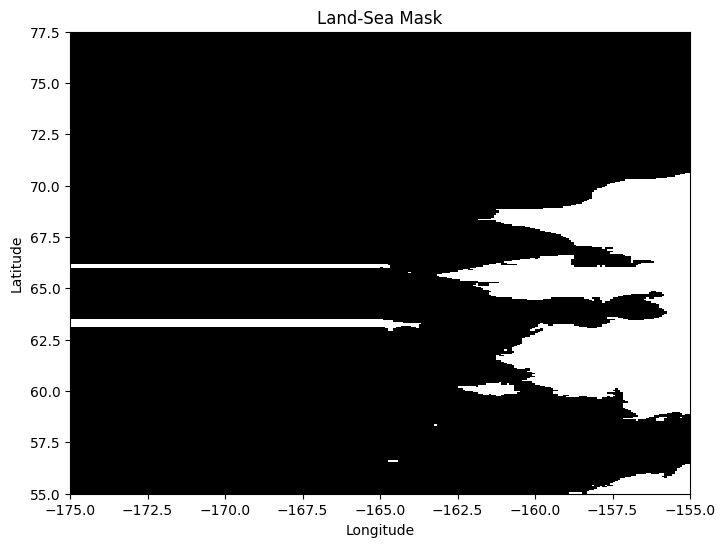

In [17]:
# Create land-sea mask
land_sea_mask = np.where(Model_bathy < 0, 1, 0)

# Plot the mask
plt.figure(figsize=(8, 6))
plt.pcolormesh(XC, YC, land_sea_mask, cmap='binary', shading='auto')
plt.title('Land-Sea Mask')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Download and Prepare External Forcing Data

## Data Source: ECCO Version 5

We will use ECCO Version 5 data for external forcing fields.

## Variables Needed
### Surface Fluxes:

Net Heat Flux (oceQnet)

Shortwave Radiation (oceQsw)

Freshwater Flux (oceFWflx)

Wind Stress Components (oceTAUX, oceTAUY)

### Sea Ice Variables:

Sea Ice Concentration (SIarea)

Sea Ice Thickness (SIheff)


# Designing External Forcing Conditions
We will create two different sets of external forcing conditions using ECCO data.

## Regular Ice Melt Scenario

Use the ECCO surface fluxes and sea ice variables as they are.

## Reduced Ice Melt Scenario
Adjust ECCO surface fluxes and sea ice variables to simulate reduced ice melt.

In [18]:
# Define data directory
ecco_data_folder = 'C:\\Users\\Daniel\\Desktop\\185C_Project\\Data\\Version5'

# Variables and file names
variables = {
    'oceQnet': 'oceQnet/oceQnet_2016.nc',
    'oceQsw': 'oceQsw/oceQsw_2016.nc',
    'oceFWflx': 'oceFWflx/oceFWflx_2016.nc',
    'oceTAUX': 'oceTAUX/oceTAUX_2016.nc',
    'oceTAUY': 'oceTAUY/oceTAUY_2016.nc',
    'SIarea': 'SIarea/SIarea_2016.nc',
    'SIheff': 'SIheff/SIheff_2016.nc',
}

# Load data into a dictionary
ecco_data = {}

for var, filename in variables.items():
    filepath = os.path.join(ecco_data_folder, 'nctiles_monthly', filename)
    print(f'Loading {var} from {filename}')
    ds = nc.Dataset(filepath)
    
    data = ds.variables[var][:]
    ecco_data[var] = data
    ds.close()


Loading oceQnet from oceQnet/oceQnet_2016.nc
Loading oceQsw from oceQsw/oceQsw_2016.nc
Loading oceFWflx from oceFWflx/oceFWflx_2016.nc
Loading oceTAUX from oceTAUX/oceTAUX_2016.nc
Loading oceTAUY from oceTAUY/oceTAUY_2016.nc
Loading SIarea from SIarea/SIarea_2016.nc
Loading SIheff from SIheff/SIheff_2016.nc


# Read ECCO Grid

In [21]:
# Step 4: Read the ECCO Grid

# Define the ECCO grid file path
ecco_grid_file = os.path.join(ecco_data_folder, 'nctiles_grid', 'GRID', 'ECCO-GRID.nc')

# Open the NetCDF grid file
print('Reading ECCO grid variables from ECCO-GRID.nc...')

ds_grid = nc.Dataset(ecco_grid_file)

# Read grid variables
ecco_XC = ds_grid.variables['XC'][:]
ecco_YC = ds_grid.variables['YC'][:]
ecco_XG = ds_grid.variables['XG'][:]
ecco_YG = ds_grid.variables['YG'][:]
ecco_hFacC = ds_grid.variables['hFacC'][:]


# Close the dataset
ds_grid.close()

print('ECCO grid variables read successfully.')



Reading ECCO grid variables from ECCO-GRID.nc...
ECCO grid variables read successfully.


/tmp/ipykernel_1048120/1786546677.py:20: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(XC_tile, YC_tile, mask_tile, cmap='binary', shading='auto')


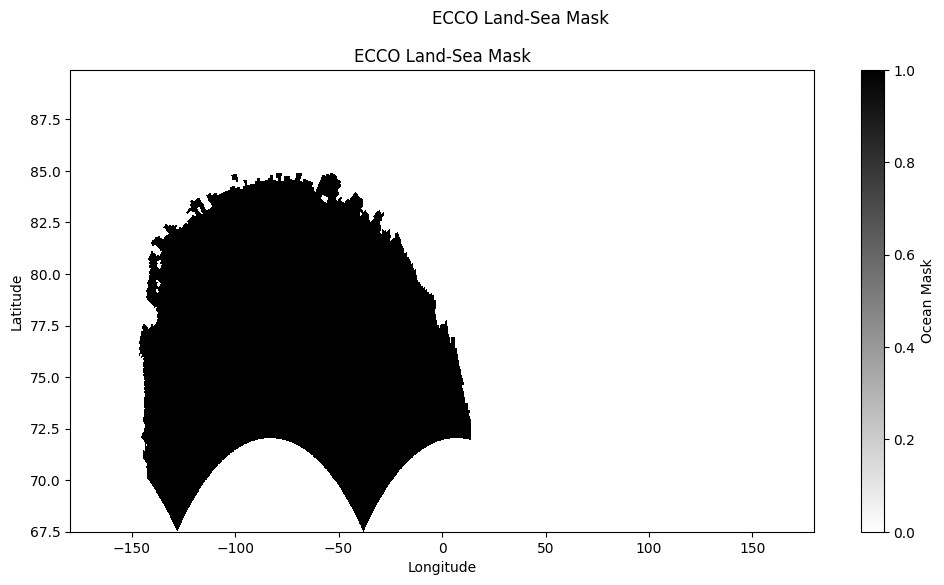

In [29]:
# For plotting, we'll select the tiles that cover our domain

lon_min = xgOrigin - 1
lon_max = xgEnd + 1
lat_min = ygOrigin - 1
lat_max = ygEnd + 1

# Initialize figure
plt.figure(figsize=(12, 6))
plt.suptitle('ECCO Land-Sea Mask')

for tile in range(ecco_XC.shape[0]):
    XC_tile = ecco_XC[tile, :, :]
    YC_tile = ecco_YC[tile, :, :]
    mask_tile = ecco_land_mask[tile, :, :]
    
    # Check if tile overlaps our domain
    if np.any((XC_tile >= lon_min) & (XC_tile <= lon_max) &
              (YC_tile >= lat_min) & (YC_tile <= lat_max)):
        plt.pcolormesh(XC_tile, YC_tile, mask_tile, cmap='binary', shading='auto')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title('ECCO Land-Sea Mask')
        plt.colorbar(label='Ocean Mask')
        plt.show()
        break  # Stop after plotting one tile covering our domain


# Prepare ECCO Data for Interpolation

We will extract data from the tiles that cover our region and mask out land points using the ECCO mask.

In [23]:
# Read ECCO grid variables
ecco_grid_file = os.path.join(ecco_data_folder, 'nctiles_grid', 'GRID', 'ECCO-GRID.nc')
ds_grid = nc.Dataset(ecco_grid_file)

ecco_XC = ds_grid.variables['XC'][:]
ecco_YC = ds_grid.variables['YC'][:]
ecco_hFacC = ds_grid.variables['hFacC'][:]
ds_grid.close()

# Extract surface hFacC to create land-sea mask
hFacC_surface = ecco_hFacC[:, 0, :, :]
ecco_land_mask = np.where(hFacC_surface > 0, 1, 0)  # 1 for ocean, 0 for land

# Initialize lists to collect data
ecco_lon_list = []
ecco_lat_list = []
ecco_data_flat = {var: [] for var in variables}

for tile in range(ecco_XC.shape[0]):
    print(f'Processing tile {tile}')
    XC_tile = ecco_XC[tile, :, :]
    YC_tile = ecco_YC[tile, :, :]
    mask_tile = ecco_land_mask[tile, :, :]

    # Filter points within our domain
    mask_lon = (XC_tile >= xgOrigin - 1) & (XC_tile <= xgEnd + 1)
    mask_lat = (YC_tile >= ygOrigin - 1) & (YC_tile <= ygEnd + 1)
    domain_mask = mask_lon & mask_lat & (mask_tile == 1)

    if not np.any(domain_mask):
        continue  # Skip tiles outside our domain or without ocean points

    ecco_lon_list.append(XC_tile[domain_mask])
    ecco_lat_list.append(YC_tile[domain_mask])

    for var in variables:
        data_tile = ecco_data[var][:, tile, :, :]
        data_tile_masked = data_tile[:, domain_mask]
        ecco_data_flat[var].append(data_tile_masked)

# Combine the lists into arrays
ecco_lon = np.concatenate(ecco_lon_list)
ecco_lat = np.concatenate(ecco_lat_list)
for var in variables:
    ecco_data_flat[var] = np.concatenate(ecco_data_flat[var], axis=1)


Processing tile 0
Processing tile 1
Processing tile 2
Processing tile 3
Processing tile 4
Processing tile 5
Processing tile 6
Processing tile 7
Processing tile 8
Processing tile 9
Processing tile 10
Processing tile 11
Processing tile 12


# Interpolate ECCO Data onto Model Grid

In [24]:
def interpolate_ecco_to_model(ecco_lon, ecco_lat, ecco_var, model_XC, model_YC, land_sea_mask):
    """
    Interpolate ECCO variable onto the model grid and apply land-sea mask.
    ecco_var: numpy array of shape (time, num_points)
    """
    num_times = ecco_var.shape[0]
    model_var = np.empty((num_times, model_YC.shape[0], model_XC.shape[1]))
    for t in range(num_times):
        print(f'Interpolating time step {t+1}/{num_times}')
        data = ecco_var[t, :]
        interpolated = griddata(
            (ecco_lon, ecco_lat),
            data,
            (model_XC, model_YC),
            method='linear'
        )
        # Fill NaNs if necessary
        nan_mask = np.isnan(interpolated)
        if np.any(nan_mask):
            interpolated[nan_mask] = griddata(
                (ecco_lon, ecco_lat),
                data,
                (model_XC[nan_mask], model_YC[nan_mask]),
                method='nearest'
            )
        # Apply land-sea mask
        interpolated *= land_sea_mask
        model_var[t, :, :] = interpolated
    return model_var


## Interpolate Variables:

In [25]:
model_forcing = {}
for var in variables:
    print(f'Interpolating {var}')
    model_forcing[var] = interpolate_ecco_to_model(
        ecco_lon,
        ecco_lat,
        ecco_data_flat[var],
        XC,
        YC,
        land_sea_mask
    )


Interpolating oceQnet
Interpolating time step 1/12
Interpolating time step 2/12
Interpolating time step 3/12
Interpolating time step 4/12
Interpolating time step 5/12
Interpolating time step 6/12
Interpolating time step 7/12
Interpolating time step 8/12
Interpolating time step 9/12
Interpolating time step 10/12
Interpolating time step 11/12
Interpolating time step 12/12
Interpolating oceQsw
Interpolating time step 1/12
Interpolating time step 2/12
Interpolating time step 3/12
Interpolating time step 4/12
Interpolating time step 5/12
Interpolating time step 6/12
Interpolating time step 7/12
Interpolating time step 8/12
Interpolating time step 9/12
Interpolating time step 10/12
Interpolating time step 11/12
Interpolating time step 12/12
Interpolating oceFWflx
Interpolating time step 1/12
Interpolating time step 2/12
Interpolating time step 3/12
Interpolating time step 4/12
Interpolating time step 5/12
Interpolating time step 6/12
Interpolating time step 7/12
Interpolating time step 8/12


## Create Reduced Ice Melt Scenario

In [32]:
# Copy data for modification
import copy
model_forcing_reduced = copy.deepcopy(model_forcing)

# Decrease net heat flux by 10%
model_forcing_reduced['oceQnet'] *= 0.9

# Increase sea ice concentration and thickness by 10%
model_forcing_reduced['SIarea'] *= 1.1
model_forcing_reduced['SIheff'] *= 1.1

model_forcing_reduced['SIarea'] = np.clip(model_forcing_reduced['SIarea'], 0, 1)


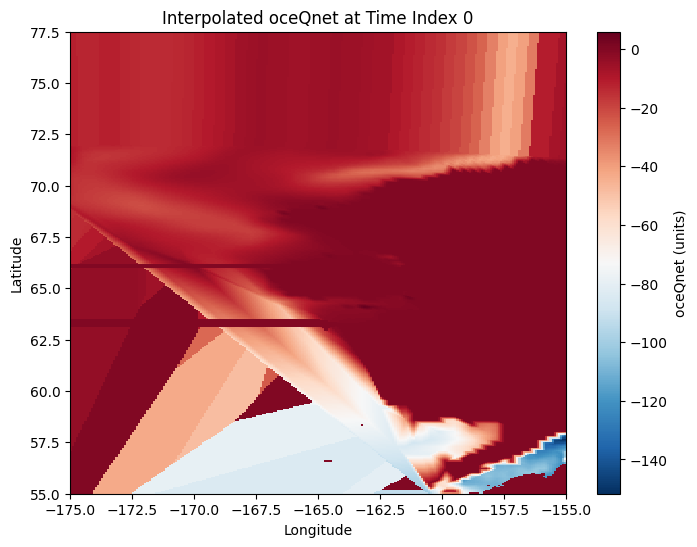

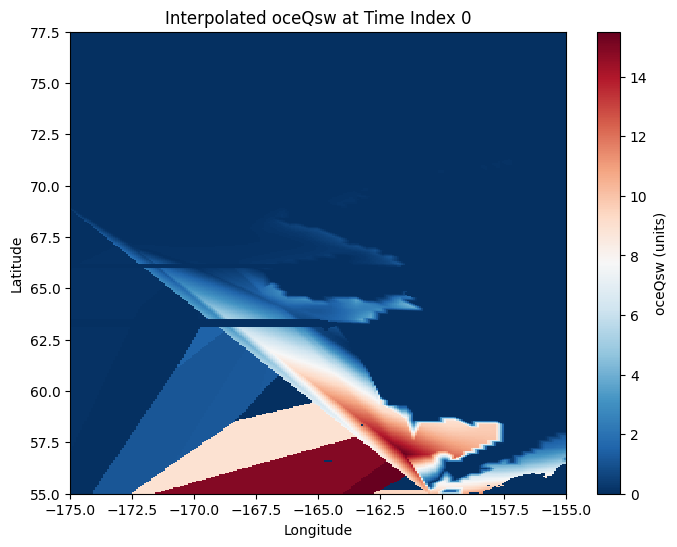

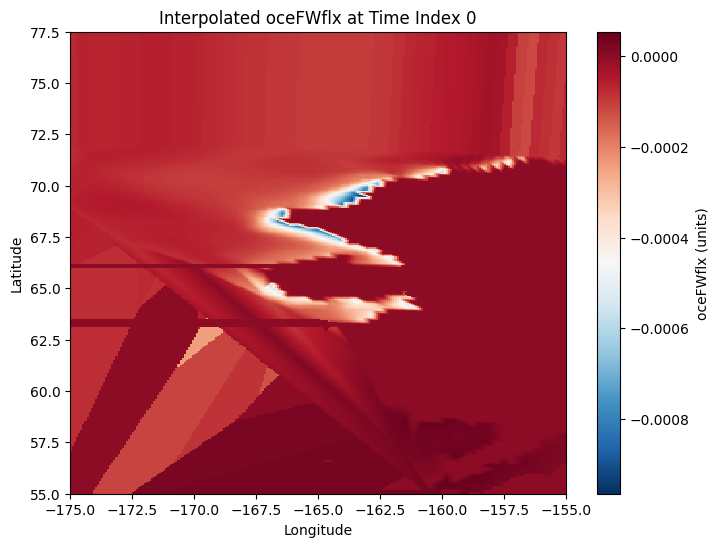

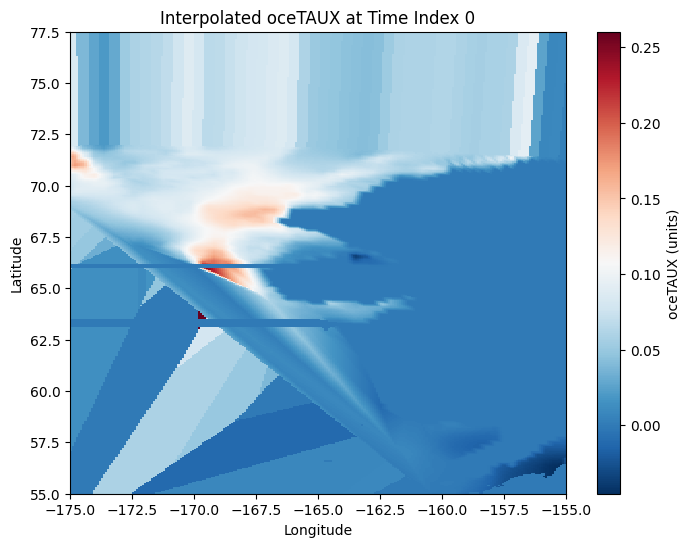

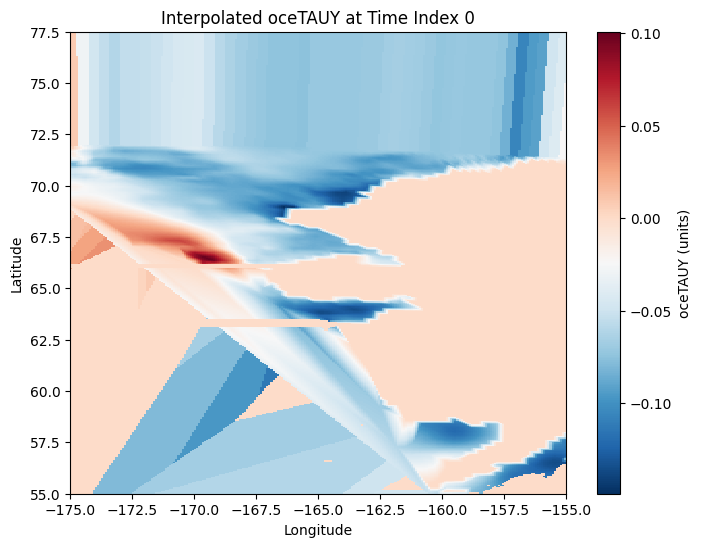

In [42]:
variables_to_plot = ['oceQnet', 'oceQsw', 'oceFWflx', 'oceTAUX', 'oceTAUY']
time_index = 0  # Select a time index

for var in variables_to_plot:
    data_to_plot = model_forcing[var][time_index, :, :]
    
    plt.figure(figsize=(8, 6))
    C = plt.pcolormesh(XC, YC, data_to_plot, cmap='RdBu_r', shading='auto')
    plt.colorbar(C, label=f'{var} (units)')
    plt.title(f'Interpolated {var} at Time Index {time_index}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


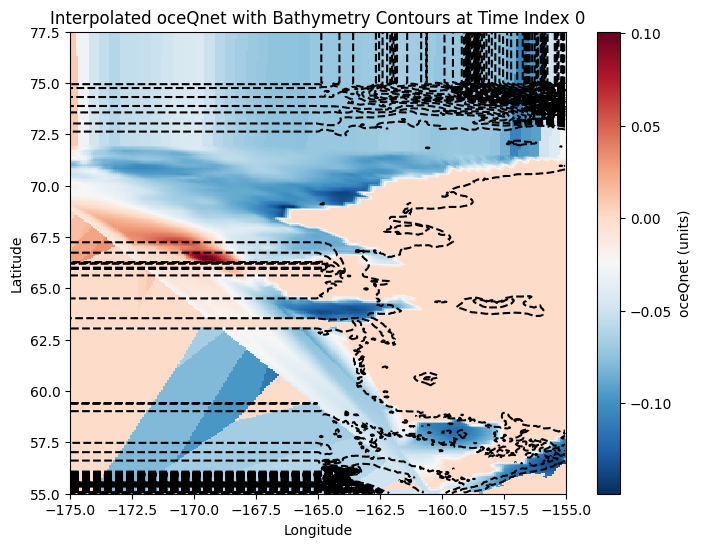

In [40]:

# Plotting the interpolated variable with bathymetry contours
plt.figure(figsize=(8, 6))
C = plt.pcolormesh(XC, YC, data_to_plot, cmap='RdBu_r', shading='auto')
plt.colorbar(C, label=f'{var_to_plot} (units)')
min_depth = np.nanmin(Model_bathy)
max_depth = np.nanmax(Model_bathy)
contour_levels = np.linspace(min_depth, max_depth, num=100)
plt.contour(XC, YC, Model_bathy, levels=contour_levels, colors='k', linestyles='--')
plt.title(f'Interpolated {var_to_plot} with Bathymetry Contours at Time Index {time_index}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



# Implementing Forcing Conditions into the Model

## Preparing Forcing Files
Save Variables as Binary Files:

In [27]:
# Define output directories
output_dir_regular = 'C:\\Users\\Daniel\\Desktop\\185C_Project\\externaloutput\\regular'
output_dir_reduced = 'C:\\Users\\Daniel\\Desktop\\185C_Project\\externaloutput\\reduced'
os.makedirs(output_dir_regular, exist_ok=True)
os.makedirs(output_dir_reduced, exist_ok=True)

def save_forcing_binary(model_var, var_name, output_dir):
    num_times = model_var.shape[0]
    for t in range(num_times):
        filename = f'{var_name}.{t+1:04d}.bin'
        filepath = os.path.join(output_dir, filename)
        print(f'Saving {var_name} time step {t+1} to {filepath}')
        model_var[t, :, :].astype('>f4').tofile(filepath)

# Save variables for both scenarios
for var in ['oceQnet', 'oceQsw', 'oceFWflx', 'oceTAUX', 'oceTAUY']:
    # Regular Scenario
    save_forcing_binary(model_forcing[var], var, output_dir_regular)
    # Reduced Ice Melt Scenario
    save_forcing_binary(model_forcing_reduced[var], var, output_dir_reduced)


Saving oceQnet time step 1 to ./output/regular/oceQnet.0001.bin
Saving oceQnet time step 2 to ./output/regular/oceQnet.0002.bin
Saving oceQnet time step 3 to ./output/regular/oceQnet.0003.bin
Saving oceQnet time step 4 to ./output/regular/oceQnet.0004.bin
Saving oceQnet time step 5 to ./output/regular/oceQnet.0005.bin
Saving oceQnet time step 6 to ./output/regular/oceQnet.0006.bin
Saving oceQnet time step 7 to ./output/regular/oceQnet.0007.bin
Saving oceQnet time step 8 to ./output/regular/oceQnet.0008.bin
Saving oceQnet time step 9 to ./output/regular/oceQnet.0009.bin
Saving oceQnet time step 10 to ./output/regular/oceQnet.0010.bin
Saving oceQnet time step 11 to ./output/regular/oceQnet.0011.bin
Saving oceQnet time step 12 to ./output/regular/oceQnet.0012.bin
Saving oceQnet time step 1 to ./outpu/reduced/oceQnet.0001.bin
Saving oceQnet time step 2 to ./outpu/reduced/oceQnet.0002.bin
Saving oceQnet time step 3 to ./outpu/reduced/oceQnet.0003.bin
Saving oceQnet time step 4 to ./outpu/re

In [28]:
# Save sea ice variables
for var in ['SIarea', 'SIheff']:
    # Regular Scenario
    save_forcing_binary(model_forcing[var], var, output_dir_regular)
    # Reduced Ice Melt Scenario
    save_forcing_binary(model_forcing_reduced[var], var, output_dir_reduced)


Saving SIarea time step 1 to ./output/regular/SIarea.0001.bin
Saving SIarea time step 2 to ./output/regular/SIarea.0002.bin
Saving SIarea time step 3 to ./output/regular/SIarea.0003.bin
Saving SIarea time step 4 to ./output/regular/SIarea.0004.bin
Saving SIarea time step 5 to ./output/regular/SIarea.0005.bin
Saving SIarea time step 6 to ./output/regular/SIarea.0006.bin
Saving SIarea time step 7 to ./output/regular/SIarea.0007.bin
Saving SIarea time step 8 to ./output/regular/SIarea.0008.bin
Saving SIarea time step 9 to ./output/regular/SIarea.0009.bin
Saving SIarea time step 10 to ./output/regular/SIarea.0010.bin
Saving SIarea time step 11 to ./output/regular/SIarea.0011.bin
Saving SIarea time step 12 to ./output/regular/SIarea.0012.bin
Saving SIarea time step 1 to ./outpu/reduced/SIarea.0001.bin
Saving SIarea time step 2 to ./outpu/reduced/SIarea.0002.bin
Saving SIarea time step 3 to ./outpu/reduced/SIarea.0003.bin
Saving SIarea time step 4 to ./outpu/reduced/SIarea.0004.bin
Saving SI